# 03 – Exploratory Data Analysis & Data Fusion

This notebook explores the cleaned data sets and demonstrates different fusion strategies (early, late and hybrid).  We compute summary statistics, generate visualisations and create derived features.

## Load cleaned data

We load the processed CSV files produced in the previous step.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

processed_dir = os.path.join(os.path.pardir, 'data', 'processed')
user_df = pd.read_csv(os.path.join(processed_dir, 'user_profile_clean.csv'))
ad_df = pd.read_csv(os.path.join(processed_dir, 'ad_feature_clean.csv'))
click_df = pd.read_csv(os.path.join(processed_dir, 'raw_sample_clean.csv'))
behaviour_df = pd.read_csv(os.path.join(processed_dir, 'behavior_log_clean.csv'))


### Early fusion

We merge user demographics, ad information and click logs on their common keys.  `user_profile` is joined on `user_id` and `ad_feature` is joined on `adgroup_id`.

In [2]:
# Merge click log with user profile
click_user = click_df.merge(user_df, left_on='user', right_on='userid', how='left')
# Merge with ad features
full_df = click_user.merge(ad_df, on='adgroup_id', how='left')

print('Early fused data shape:', full_df.shape)

# Save for later use
full_df.to_csv(os.path.join(processed_dir, 'full_fusion.csv'), index=False)


Early fused data shape: (100000, 20)


### Hybrid fusion features

In addition to early fusion, we derive aggregate features from the behaviour log, such as the number of page views (pv), carts, favourites and purchases per user.

In [3]:
# Aggregate behaviour counts per user
behaviour_counts = behaviour_df.pivot_table(index='user', 
                                            columns='btag', 
                                            values='time_stamp', 
                                            aggfunc='count', 
                                            fill_value=0).reset_index()
# Rename columns for clarity
behaviour_counts.columns = ['user'] + [f'btag_{c}_count' for c in behaviour_counts.columns[1:]]

# Merge aggregated behaviour with full_df
full_df = full_df.merge(behaviour_counts, left_on='user', right_on='user', how='left')

# Replace any remaining NaN values with zero for counts
for col in full_df.filter(like='btag_').columns:
    full_df[col] = full_df[col].fillna(0)

print('Hybrid fused data shape:', full_df.shape)

# Save hybrid fused data
full_df.to_csv(os.path.join(processed_dir, 'hybrid_fusion.csv'), index=False)


Hybrid fused data shape: (100000, 24)


### Univariate analysis

We explore the distributions of key numeric features using histograms and boxplots.

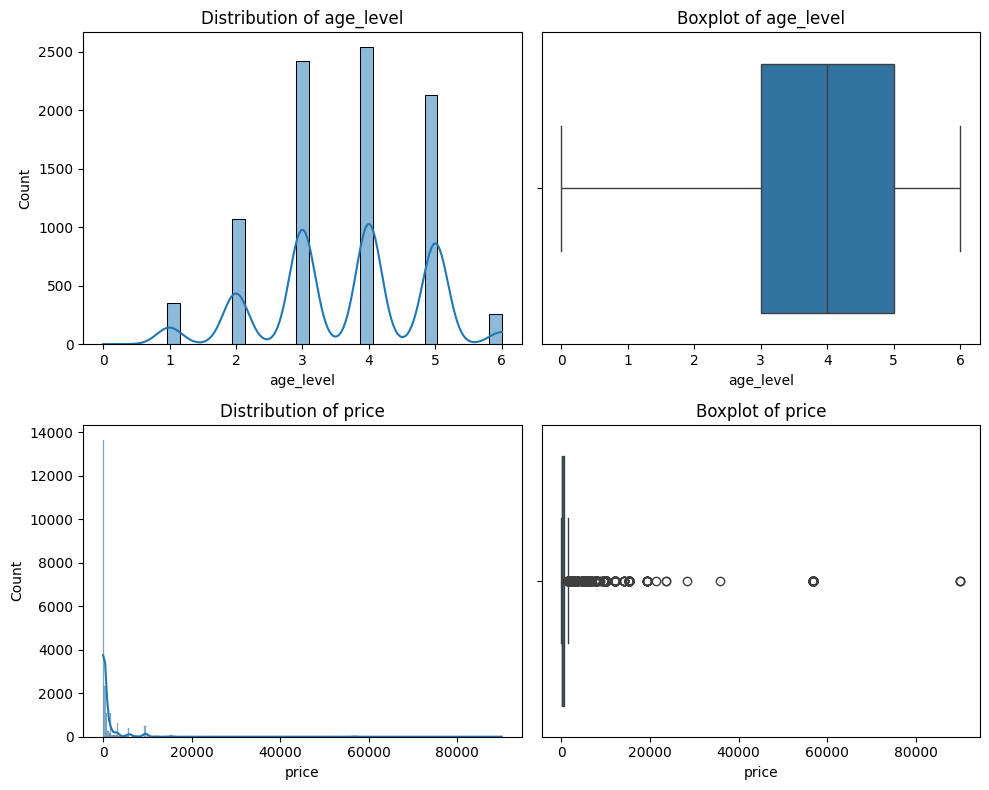

In [4]:
numeric_cols = ['age_level', 'price']
fig, axes = plt.subplots(len(numeric_cols), 2, figsize=(10, 4 * len(numeric_cols)))
for i, col in enumerate(numeric_cols):
    sns.histplot(full_df[col], ax=axes[i, 0], kde=True)
    axes[i, 0].set_title(f'Distribution of {col}')
    sns.boxplot(x=full_df[col], ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()


### Correlation heatmap

A heatmap visualises pairwise correlations among numeric variables.

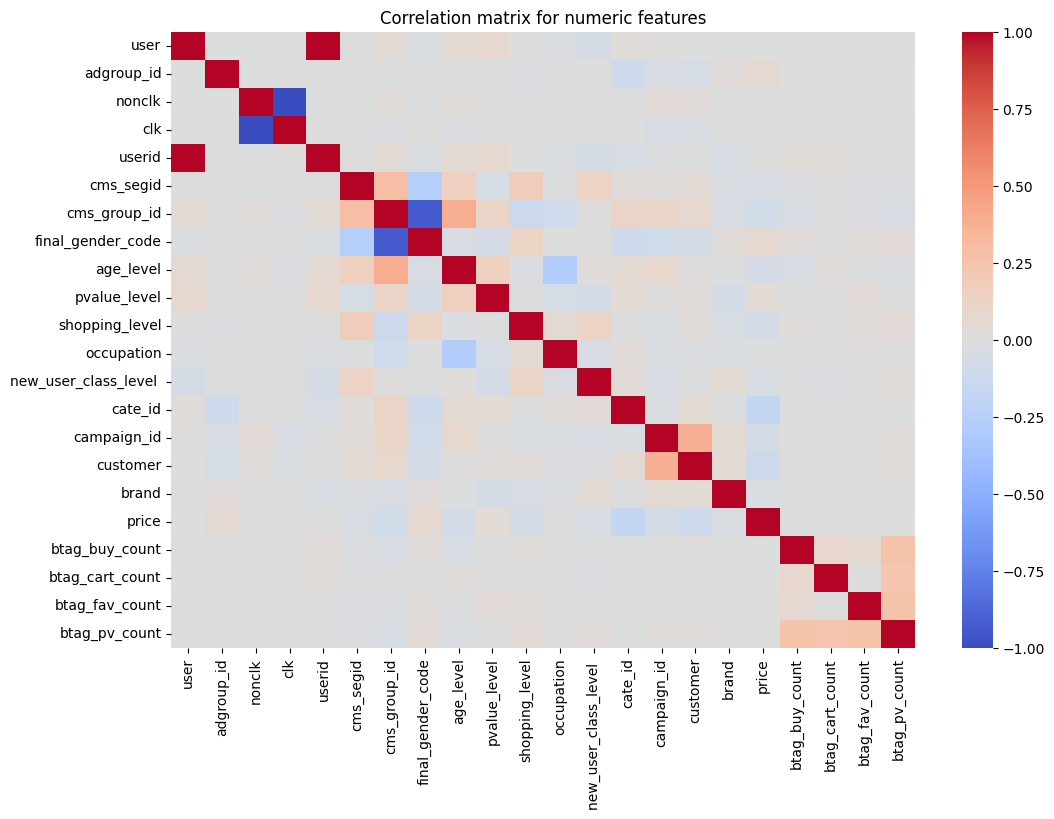

In [5]:
# Compute correlation matrix for numeric columns
corr_cols = full_df.select_dtypes(include=[np.number]).columns
corr = full_df[corr_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
plt.title('Correlation matrix for numeric features')
plt.show()
